## Generating some iron flux forcing plots

This notebook reads in the CESM1 historical run (for CMIP5),
the ensemble of 11 CESM2 historical runs (for CMIP6),
and the two SSP5-8.5 CESM2 historical runs (also for CMIP6).

Two time series plots are generated from global annual averages of iron flux.
One compares the CESM2 and CESM1 historical runs
(with CESM2 showing individual ensemble members as well as the ensemble mean).
The other also adds the two SSP5-8.5 runs and their means.

Lastly, a surface plot showing the 1995-2014 [ensemble] mean from CESM2 is generated.

### This notebook uses several python packages

The watermark package shows the version number used to help others recreate this environment.

In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
%load_ext watermark
%watermark -a "Mike Levy" -d -iv -m -g -h

cmocean    2.0
numpy      1.17.3
cftime     1.0.3.4
intake     0.5.3
intake_esm 2019.10.15.post33
xarray     0.14.0
esmlab     2019.4.27.post55
cartopy    0.17.0
matplotlib 3.1.2
Mike Levy 2019-11-14 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper02
Git hash   : beabcb49dcc1ade9ecd64ea528bbc294c98beccb


### Read the intake_esm datastores

The `intake_esm` package is used to help identify which files belong in each experiment.

In [2]:
#cesm2 = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign_via_glade-cmip6_NOT_CMORIZED.json')
cesm2 = intake.open_esm_datastore('/glade/work/mlevy/intake-esm-collection/json/campaign-cesm2-cmip6-timeseries.json')

#cesm1 = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip5_NOT_CMORIZED.json')
cesm1 = intake.open_esm_datastore('/glade/work/mlevy/intake-esm-collection/json/glade-cesm1-cmip5-timeseries.json')

### Produce xarray datasets

For this notebook, we will drop all the data except `IRON_FLUX`, `TAREA`, and coordinate data.

In [3]:
dq = dict()
datasets = dict()

# CESM2 Datasets
# Although we do only look at historical and 'SSP5-8.5', the other SSPs are also available
dq['cesm2'] = cesm2.search(experiment=['historical', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'], variable='IRON_FLUX').to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})

datasets['cesm2_hist'] = dq['cesm2']['ocn.historical.pop.h']
datasets['cesm2_SSP'] = dq['cesm2']['ocn.SSP5-8.5.pop.h']

# CESM1 Datasets
dq['cesm1'] = cesm1.search(experiment='historical', variable='IRON_FLUX').to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})

datasets['cesm1_hist'] = dq['cesm1']['ocn.historical.pop.h']

keep_vars = ['TAREA', 'TLONG', 'TLAT', 'IRON_FLUX', 'time', 'time_bound', 'member_id']
for exp in datasets:
    datasets[exp] = datasets[exp].drop([v for v in datasets[exp].variables if v not in keep_vars])
    print(f'\n{exp}\n----\n{datasets[exp]}')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 5 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)

cesm2_hist
----
<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 1980)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time        (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(48, 2), meta=np.ndarray>
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1980, 384, 320), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) flo

### Compute annual means

For now this uses `esmlab`, but it may switch to `time_axes` in the future

In [4]:
%%time

datasets_ann = dict()
for exp in datasets:
    datasets_ann[exp] = esmlab.resample(datasets[exp], freq='ann')
    print(f'\n{exp}\n----\n{datasets_ann[exp]}')


cesm2_hist
----
<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 165)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * time        (time) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (d2, time) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
Attributes:
    history:  \n2019-11-14 11:49:52.390748 esmlab.resample(<DATASET>, freq="a...

cesm2_SSP
----
<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 2, nlat: 384, nlon: 320, time: 86)
Coordinates:
  * member_id   (me

### Compute global means of iron flux

Using the previously computed annual means, compute global means (weighted by area)

In [5]:
%%time

iron_flux_glb = dict()
for exp in datasets_ann:
    iron_flux_glb[exp] = esmlab.weighted_sum(datasets_ann[exp].IRON_FLUX, dim=['nlat', 'nlon'], weights=datasets_ann[exp].isel(time=0).TAREA)
    iron_flux_glb[exp] = iron_flux_glb[exp] * 1.0e-16 * 365.0 * 86400.0 # mmolFe/m^2/s to GmolFe/y
    iron_flux_glb[exp].attrs['units'] = 'Gmol Fe yr$^{-1}$'
    iron_flux_glb[exp] = iron_flux_glb[exp].compute()
    print(f'\n{exp}\n----\n{iron_flux_glb[exp]}')

# SSP5-8.5 extends runs .010 and .011 from historical
# Updating the member_id coord in this array will continue the correct lines
# when the historical flux and SSP flux are concatenated
iron_flux_glb['cesm2_SSP'].member_id.values = [10,11]

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)



cesm2_hist
----
<xarray.DataArray (member_id: 11, time: 165)>
array([[9.2300802 , 8.26259593, 8.22607918, ..., 8.87160024, 8.82485228,
        8.11518775],
       [8.32685797, 7.26389874, 8.52567667, ..., 8.69017733, 9.25795746,
        8.37191988],
       [8.1106605 , 8.38003757, 8.23106228, ..., 7.89537625, 8.13547233,
        8.61778304],
       ...,
       [7.61386383, 7.59802859, 8.1020224 , ..., 8.35342317, 8.31701001,
        7.52157364],
       [8.81659523, 7.76057121, 8.21183624, ..., 8.43592903, 7.45949937,
        9.3636691 ],
       [8.24144115, 9.43141237, 9.26289287, ..., 8.58407975, 7.95796275,
        8.55384729]])
Coordinates:
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * time       (time) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
Attributes:
    units:    Gmol Fe yr$^{-1}$


/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)



cesm2_SSP
----
<xarray.DataArray (member_id: 2, time: 86)>
array([[ 8.50941224,  8.95658596,  6.89334451,  8.09113533,  8.79494933,
         8.91342649,  8.59172107,  8.63069986,  8.41060304,  8.002759  ,
         8.4508194 ,  7.99338067,  8.42508366,  7.55560233,  8.35969637,
         8.18961598,  8.41620727,  8.22138342,  8.09406658,  8.779661  ,
         8.48598679,  8.60912174,  9.40905072,  8.92782263,  8.45813898,
         7.70180446,  8.73319542,  7.76943063,  7.99768089,  8.48826344,
         7.55043843,  7.61723609,  8.10237427,  8.48310176,  9.0461542 ,
         8.12362452,  8.4391531 ,  9.58798856,  7.08141449,  8.52440359,
         7.88873817,  7.76163151,  8.88533361,  8.43163524,  8.35510453,
         8.51232801,  8.65835539,  9.71359375,  8.85675724,  7.6585737 ,
         8.39870355,  7.87915094,  8.03037773,  9.73974864,  7.82646079,
         8.94077749,  8.42677704,  7.65742815,  8.04642777,  8.04416214,
         9.17825696,  8.02027099,  9.22576783,  9.40905217,  9.1

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)



cesm1_hist
----
<xarray.DataArray (member_id: 1, time: 156)>
array([[6.61582808, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312

### Time Series plots

Plot just the historical period and then include the future as well.

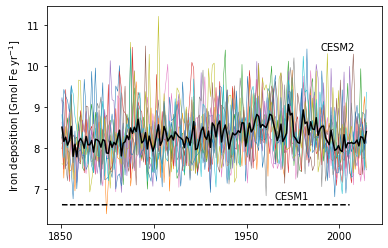

In [6]:
plot_name = f'timeseries.global.historical.IRON_FLUX.pdf'

fig = plt.figure()
ax = fig.add_subplot(111)
for i in iron_flux_glb['cesm2_hist'].member_id.values:
    ax.plot(iron_flux_glb['cesm2_hist'].time, iron_flux_glb['cesm2_hist'].sel(member_id=i), linewidth=0.5)

ax.plot(iron_flux_glb['cesm2_hist'].time, iron_flux_glb['cesm2_hist'].mean('member_id'), color='k', linewidth=1.5)    

ax.plot(iron_flux_glb['cesm1_hist'].time, iron_flux_glb['cesm1_hist'].isel(member_id=0), linestyle='--', color='k', linewidth=1.5)    

ax.set_ylabel('Iron deposition [Gmol Fe yr$^{-1}$]');

ax.text(cftime.DatetimeNoLeap(1990, 1, 1), iron_flux_glb['cesm2_hist'].sel(time='1990').max('member_id')*1.05, 'CESM2',color='k');

ax.text(cftime.DatetimeNoLeap(1965, 1, 1), iron_flux_glb['cesm1_hist'].sel(time='1960')*1.02, 'CESM1',color='k');

#plt.savefig(plot_name,dpi=300,bbox_inches='tight')

In [7]:
iron_flux_glb_combine = xr.concat([iron_flux_glb['cesm2_hist'], iron_flux_glb['cesm2_SSP']], dim='time', join='outer')
print(iron_flux_glb_combine)

<xarray.DataArray (member_id: 11, time: 251)>
array([[ 9.2300802 ,  8.26259593,  8.22607918, ...,         nan,
                nan,         nan],
       [ 8.32685797,  7.26389874,  8.52567667, ...,         nan,
                nan,         nan],
       [ 8.1106605 ,  8.38003757,  8.23106228, ...,         nan,
                nan,         nan],
       ...,
       [ 7.61386383,  7.59802859,  8.1020224 , ...,         nan,
                nan,         nan],
       [ 8.81659523,  7.76057121,  8.21183624, ..., 10.16191429,
         8.31866853,  8.55801803],
       [ 8.24144115,  9.43141237,  9.26289287, ...,  9.00592413,
        10.1751668 ,  8.96284567]])
Coordinates:
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * time       (time) object 1850-07-01 17:05:00 ... 2100-07-01 17:00:00
Attributes:
    units:    Gmol Fe yr$^{-1}$


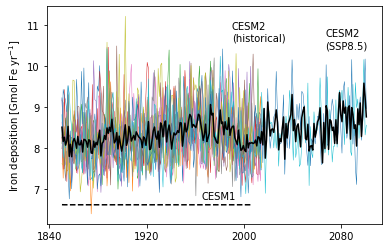

In [8]:
plot_name = f'timeseries.global.historical-SSP585.IRON_FLUX.pdf'

fig = plt.figure()
ax = fig.add_subplot(111)
for i in iron_flux_glb_combine.member_id.values:
    ax.plot(iron_flux_glb_combine.time, iron_flux_glb_combine.sel(member_id=i), linewidth=0.5)

ax.plot(iron_flux_glb_combine.time, iron_flux_glb_combine.mean('member_id'), color='k', linewidth=1.5)    

ax.plot(iron_flux_glb['cesm1_hist'].time, iron_flux_glb['cesm1_hist'].isel(member_id=0), linestyle='--', color='k', linewidth=1.5)    

ax.set_ylabel('Iron deposition [Gmol Fe yr$^{-1}$]');

ax.text(cftime.DatetimeNoLeap(1990, 1, 1), iron_flux_glb['cesm2_hist'].sel(time='1990').max('member_id')*1.075, 'CESM2\n(historical)',color='k');
ax.text(cftime.DatetimeNoLeap(2067, 1, 1), iron_flux_glb_combine.sel(time='2067').max('member_id')*1.04, 'CESM2\n(SSP8.5)',color='k');

ax.text(cftime.DatetimeNoLeap(1965, 1, 1), iron_flux_glb['cesm1_hist'].sel(time='1960')*1.02, 'CESM1',color='k');

#plt.savefig(plot_name,dpi=300,bbox_inches='tight')

### Spatial Plot

The ensemble mean averaged between 1995 and 2014 from the CESM2 historical run.

In [9]:
%%time

mmolm2s_to_molm2yr = 1e-3 * 86400. * 365.
iron_flux_map = datasets_ann['cesm2_hist'].IRON_FLUX.sel(time=slice('1995', '2014')).mean(['time', 'member_id'])
iron_flux_map = iron_flux_map.compute() * mmolm2s_to_molm2yr

print(f'Min value: {iron_flux_map.min().values}')
print(f'Max value: {iron_flux_map.max().values}')
iron_flux_map

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Min value: 1.937666894447467e-08
Max value: 0.0010497160800971874
CPU times: user 17 s, sys: 4.96 s, total: 21.9 s
Wall time: 20.5 s


<xarray.DataArray 'IRON_FLUX' (nlat: 384, nlon: 320)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [4.01281948e-08, 3.76392364e-08, 3.66805627e-08, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
Dimensions without coordinates: nlat, nlon

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


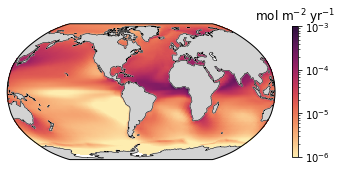

In [10]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))


pc = ax.pcolormesh(iron_flux_map.TLONG, iron_flux_map.TLAT, iron_flux_map,
                   norm=colors.LogNorm(vmin=1e-6, vmax=1e-3),
                   cmap=cmocean.cm.matter,
                   transform=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                                   edgecolor='face',
                                                   facecolor='lightgray'))
ax.set_global() 
ax.coastlines(linewidth=0.5)
cb = plt.colorbar(pc, shrink=0.6)
cb.ax.set_title('mol m$^{-2}$ yr$^{-1}$');